# 1 WEEK DRIFT DETECTION SYTH

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
import colorsys
import numpy as np
import seaborn as sns



#### Load inn the raw dataset

In [2]:
df_1_week = pd.read_csv('../datasets/files/SYNTHETIC_1_week_drift.csv')
df_ensemble = pd.read_csv('../results/ensemble/test_syntic_test_100.csv')

def parse_drifts(d):
    d = d.strip('"')  # remove extra quotes if present
    return ast.literal_eval(d)

df_ensemble['drifts'] = df_ensemble['drifts'].apply(parse_drifts)

loaded_dict = dict(zip(df_ensemble['model_name'], df_ensemble['drifts']))

# Extract all algorithms
all_algorithms = set()
for algorithm in loaded_dict.keys():
        all_algorithms.add(algorithm)

all_algorithms = list(all_algorithms)
num_algorithms = len(all_algorithms)

### Ensemble

[('BayesianNonparametricDetectionMethod', [3300]), ('ClusteredStatisticalTestDriftDetectionMethod', [3192, 4192]), ('KullbackLeiblerDistanceDetector', [3268]), ('HellingerDistanceDetector', [3268])]


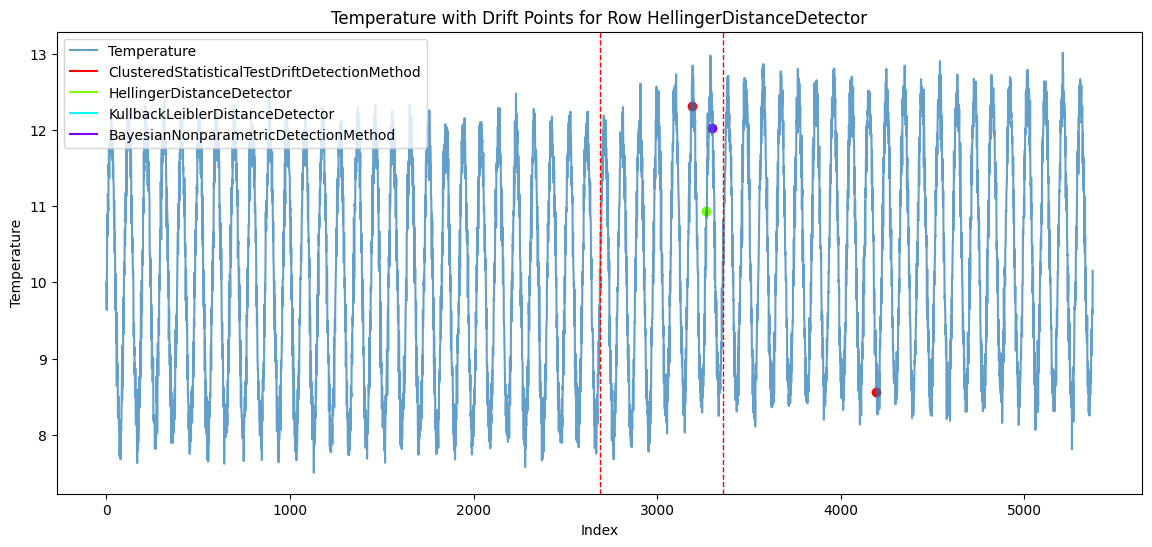

In [3]:
# Assign a random color to each algorithm
# We can pick from a colormap or just generate random colors using np.random
color_map = {}
for i, alg in enumerate(all_algorithms):
    hue = i / num_algorithms  # evenly spaced hues between 0 and 1
    # Full saturation (1.0) and full value/brightness (1.0) for vivid colors
    r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
    color_map[alg] = (r, g, b)

rows_with_drift = []
for idx, row_value in loaded_dict.items():
    any_drift = len(row_value) > 0
    if any_drift:
        rows_with_drift.append((idx, row_value))

if not rows_with_drift:
    print("No drifts found in the entire dataset")
else:
    print(rows_with_drift)
    plt.figure(figsize=(14, 6))
    # Plot baseline temperature
    plt.plot(df_1_week["temperature"], alpha=0.7, label='Temperature')
    # Add a dummy line for each algorithm to appear in the legend
    for algorithm, alg_color in color_map.items():
        plt.plot([], [], color=alg_color, label=algorithm)
    # Plot drift points
    for row_index, drift_points in rows_with_drift:
        alg_color = color_map[row_index]
        for drift_point in drift_points:
            plt.scatter(int(drift_point), df_1_week["temperature"].iloc[int(drift_point)], color=alg_color)

    drift_start = 4 * 672
    drift_end = 5 * 672
    plt.axvline(x=drift_start, color='red', linestyle='--', linewidth=1)
    plt.axvline(x=drift_end, color='red', linestyle='--', linewidth=1)
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.title(f'Temperature with Drift Points for Row {row_index}')
    plt.legend()
    plt.show()


# Finding window with highest number of drift

Analyzing drifts for row the dataset
[3300, 3192, 4192, 3268, 3268]
Window results (start, end, drift_count):
(0, 999, 0)
(500, 1499, 0)
(1000, 1999, 0)
(1500, 2499, 0)
(2000, 2999, 0)
(2500, 3499, 4)
(3000, 3999, 4)
(3500, 4499, 1)
(4000, 4999, 1)

The highest number of drifts in a window is 4
Window 2500-3499 has 4 drifts
Window 3000-3999 has 4 drifts


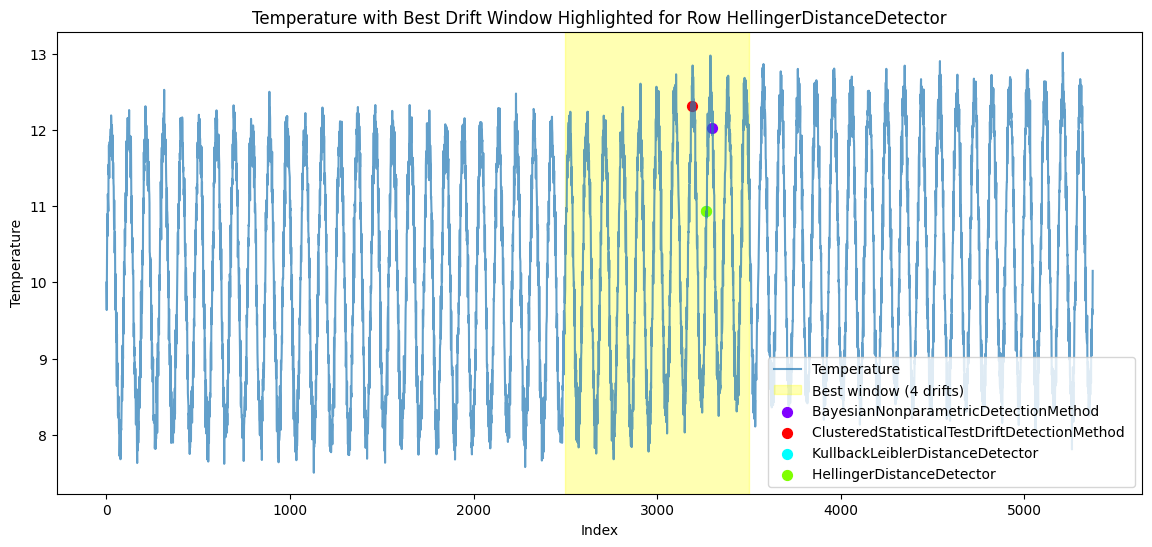

In [4]:
# Assign a random color to each algorithm using HSV for vivid colors
color_map = {}
for i, alg in enumerate(all_algorithms):
    hue = i / num_algorithms
    r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
    color_map[alg] = (r, g, b)


if len(loaded_dict) == 0:
    print("No drifts found in the entire dataset")
else:
    # Now we loop over each row in rows_with_drift
        print(f"Analyzing drifts for row the dataset")

        # All drift points from all algorithms in a single row
        all_drift_points = []
        for drift in df_ensemble['drifts']:
            all_drift_points.extend(drift)
        print(all_drift_points)

        all_drift_points = sorted(all_drift_points)

        # Sliding window parameters
        window_size = 1000
        step = window_size // 2  # 50% overlap
        data_length = len(df_1_week["temperature"])

        # List to store (start_index, end_index, number_of_drifts)
        window_results = []

        start = 0
        while start + window_size <= data_length:
            end = start + window_size - 1
            # Count how many drifts fall within [start, end]
            drift_count = sum(1 for dp in all_drift_points if start <= dp <= end)
            window_results.append((start, end, drift_count))
            start += step

        # Find the window(s) with the highest number of drifts
        max_drifts = max(w[2] for w in window_results)
        max_windows = [w for w in window_results if w[2] == max_drifts]

        print("Window results (start, end, drift_count):")
        for w in window_results:
            print(w)

        print(f"\nThe highest number of drifts in a window is {max_drifts}")
        for w in max_windows:
            print(f"Window {w[0]}-{w[1]} has {w[2]} drifts")

        # Optional: Plotting the best window(s)
        if max_windows:
            best_window = max_windows[0]
            bw_start, bw_end, bw_count = best_window

            plt.figure(figsize=(14,6))
            plt.plot(df_1_week["temperature"], alpha=0.7, label='Temperature')
            plt.axvspan(bw_start, bw_end, color='yellow', alpha=0.3, label=f'Best window ({bw_count} drifts)')

            # Plot drift points
            for algorithm, drift_points in loaded_dict.items():
                alg_color = color_map.get(algorithm, 'black')
                for dp in drift_points:
                    if bw_start <= dp <= bw_end:
                        plt.scatter(dp, df_1_week["temperature"].iloc[dp], label=f'{algorithm} ', color=alg_color, s=50)

            plt.xlabel('Index')
            plt.ylabel('Temperature')
            plt.title(f'Temperature with Best Drift Window Highlighted for Row {row_index}')
            plt.legend()
            plt.show()


# Distrobution plot of the detected drifts compared to the original data

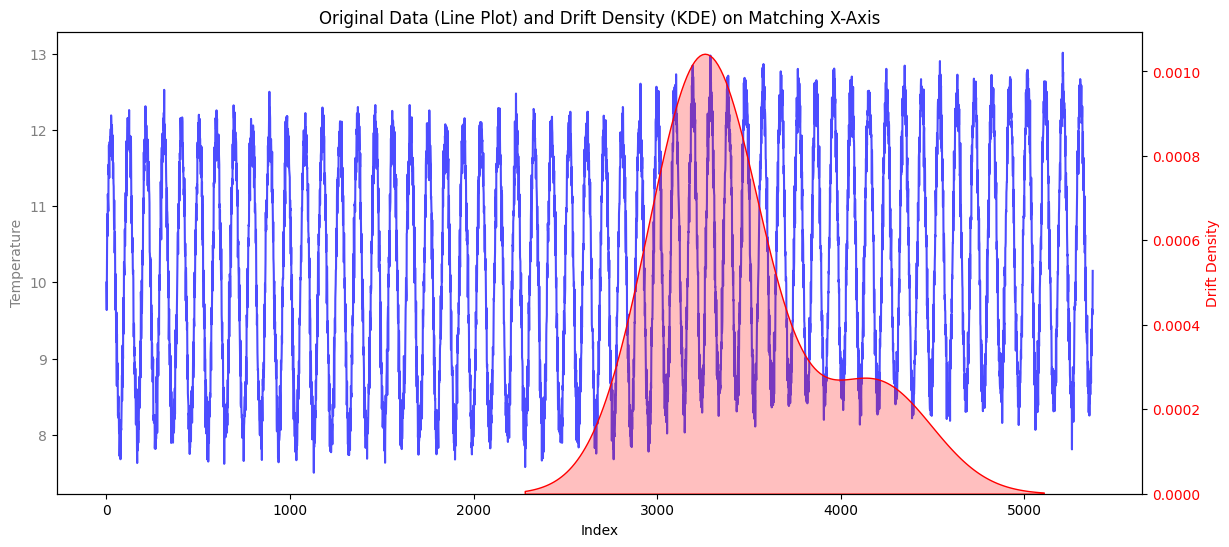

In [5]:
df_1_week = df_1_week.reset_index(drop=True)

# Assign colors
color_map = {}
for i, alg in enumerate(all_algorithms):
    hue = i / num_algorithms
    r, g, b = colorsys.hsv_to_rgb(hue, 1.0, 1.0)
    color_map[alg] = (r, g, b)


# Combine all drift points
all_drift_points = []
for drift in df_ensemble['drifts']:
    all_drift_points.extend(drift)

all_drift_points = sorted(all_drift_points)

if not all_drift_points:
    print("No drifts found in the entire dataset")
else:
    all_drift_points = sorted(all_drift_points)

    fig, ax1 = plt.subplots(figsize=(14,6))

    # Plot the original data over a numeric x-axis
    x_values = np.arange(len(df_1_week))
    ax1.plot(x_values, df_1_week["temperature"], alpha=0.7, color='blue', label='Temperature')
    ax1.set_xlabel('Index')
    ax1.set_ylabel('Temperature', color='gray')
    ax1.tick_params(axis='y', labelcolor='gray')

    # Create twin axis for density
    ax2 = ax1.twinx()

    # Use clip to constrain the kde within the data range
    x_min, x_max = ax1.get_xlim()  # Should be (0, len(df_1_week)-1)
    sns.kdeplot(all_drift_points, fill=True, ax=ax2, color='red', clip=(x_min, x_max), label=f'Drift Density')

    # Set y-label for density
    ax2.set_ylabel('Drift Density', color='red')
    ax2.tick_params(axis='y', labelcolor='red')

    # Ensure x-limits match
    ax2.set_xlim(ax1.get_xlim())

    plt.title('Original Data (Line Plot) and Drift Density (KDE) on Matching X-Axis')
    plt.show()
